In [1]:
from shared import get_clean_data

print("Normalizing data (or loaded pre-computed)")
%time edges, num_edges, num_nodes = get_clean_data(shuffle=True)
%time unshuffled_edges, unshuffled_num_edges, unshuffled_num_nodes = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Parsing from zip. Will write to file /home/sami/py-graph/LJ-cleaned-shuffled.npy
ORIGINAL DIST: 1349.1044268649273 MIN: 0 MAX: 4038
CPU times: user 312 ms, sys: 3.91 ms, total: 316 ms
Wall time: 316 ms
Parsing from zip. Will write to file /home/sami/py-graph/LJ-cleaned.npy
ORIGINAL DIST: 289.4173561212231 MIN: 0 MAX: 4038
CPU times: user 185 ms, sys: 12.1 ms, total: 197 ms
Wall time: 197 ms

EDGES SHAPE: (176468, 2)


In [2]:
%load_ext Cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    import time
    
    #print ("EDGES:{}".format(len_edges))
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
            #print("Found a new node")
            #print("\tleft: {}".format(left))
            #print("\tright: {}".format(right))
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left
            
            #print("\tpartition_sizes for {}: {}".format(partition_sizes[max_arg], max_arg))
            #print("\tmax_arg: {}".format(max_arg))
            #print("\tmax_val: {}".format(max_val))

            #time.sleep(1)
            
        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [4]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Ratio of edges crossing partitions')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [5]:
from shared import score

def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE\tCUT')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()

    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, num_nodes, num_partitions, assignments)
        (waste, edge_score, edges_cut) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}\t{}'.format(i, waste, edge_score, edges_cut))
    
    with open("assignments.txt", "w") as f:
        j = 0
        for a in assignments:
            #print("\t{} {}".format(j,a))
            f.write("{} {}\n".format(j,a))
            j += 1
    #print(repr(assignments))
    draw_figures(waste_values, edge_score_values, num_partitions)


4 PARTITIONS
ROUND	WASTE	SCORE	CUT
0	0.001	0.286	50404
1	0.001	0.086	15220
2	0.001	0.070	12436
3	0.001	0.074	13048
4	0.001	0.071	12512
5	0.001	0.068	11934
6	0.001	0.073	12796
7	0.001	0.082	14434
8	0.001	0.063	11142
9	0.001	0.058	10260
10	0.001	0.056	9950
11	0.001	0.056	9872
12	0.001	0.054	9584
13	0.001	0.051	9026
14	0.001	0.052	9114
CPU times: user 167 ms, sys: 3.68 ms, total: 171 ms
Wall time: 170 ms


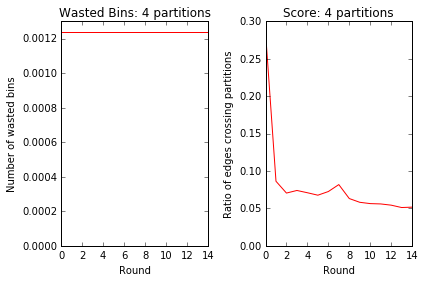

In [6]:
# Use the greedy method to break into 4 partitions
%time run_restreaming_greedy(edges, num_nodes, num_partitions=4, num_iterations=15)


40 PARTITIONS
ROUND	WASTE	SCORE	CUT
0	0.367	0.696	122898
1	0.367	0.600	105854
2	0.367	0.553	97564
3	0.367	0.518	91410
4	0.367	0.505	89180
5	0.367	0.489	86340
6	0.367	0.479	84536
7	0.367	0.482	85118
8	0.367	0.479	84588
9	0.367	0.479	84616
10	0.367	0.475	83804
11	0.367	0.475	83826
12	0.367	0.479	84530
13	0.367	0.478	84412
14	0.367	0.476	84046
CPU times: user 179 ms, sys: 7.94 ms, total: 187 ms
Wall time: 186 ms


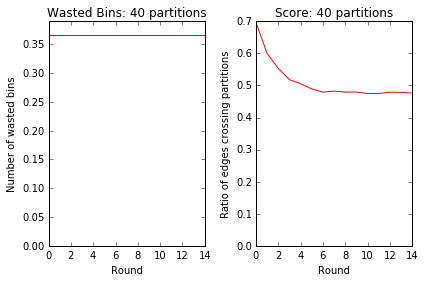

In [7]:
# Use the greedy method to break into 20 partitions
%time run_restreaming_greedy(edges, num_nodes, num_partitions=40, num_iterations=15)